In [1]:
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('labelled.csv').iloc[:,0:2]
data

,sentence,label
0,The buses didn't start arriving until almost 7...,O
1,"visit the visitors center , lots of informatio...",T
2,"And if you are looking for a w.c., one good pl...",T
3,Impressive and absolutely gorgeous.,E
4,They told me on the phone that I should have b...,O
...,...,...
4035,It can sometimes be best to go when it's cloud...,T
4036,"It doesn't obstruct the views, but it does cut...",T
4037,Check the Miami Trolley website and “track my ...,T
4038,"Service can be gruff at times, but it'll alway...",T


In [3]:
data['sentence'].iloc[0]

"The buses didn't start arriving until almost 7:30 and by that time the line is long."

In [4]:
X, y = data['sentence'], data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

Text(0, 0.5, 'Count')

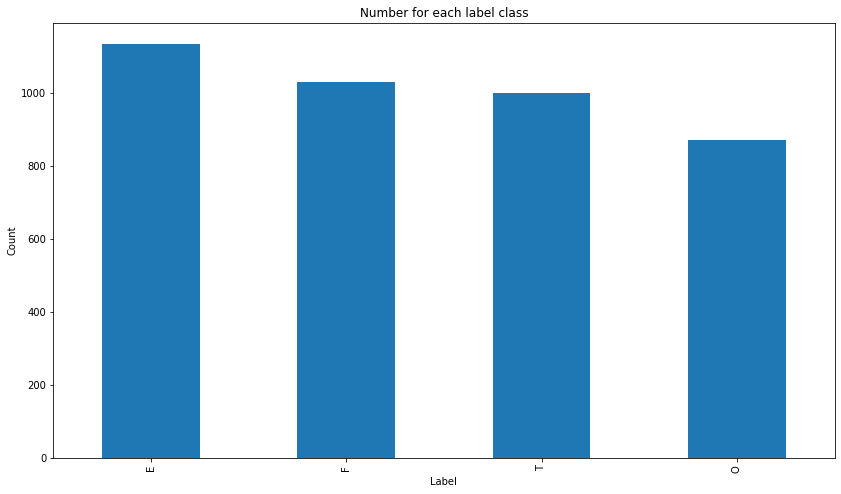

In [6]:
import matplotlib.pyplot as plt
ax = data['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each label class")
ax.set_xlabel("Label")
ax.set_ylabel("Count")

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(data['sentence']).toarray()
labels = data.label
features.shape

(4040, 1556)

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(data['sentence'], data['label'], random_state = 0)

X_train, X_test = pd.read_csv('labelled_train.csv')['sentence'], pd.read_csv('labelled_test.csv')['sentence']
y_train, y_test = pd.read_csv('labelled_train.csv')['label'], pd.read_csv('labelled_test.csv')['label']

count_vect = CountVectorizer(min_df=5, 
                             encoding='latin-1', ngram_range=(1, 4))
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [9]:
print(clf.predict(count_vect.transform(['Also, its absolutely no bags in the crown, not even little ones, so you have to use the lockers anyways.'])))

['T']


/Users/yuconghu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/yuconghu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


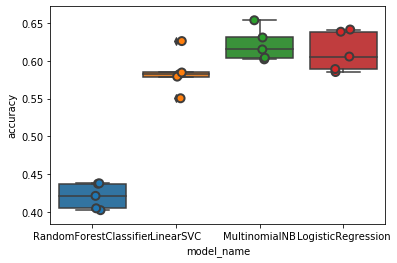

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    ]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tfidf, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
        cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
        
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [11]:
from sklearn.model_selection import GridSearchCV

# logistic = LogisticRegression(random_state=0)
clf = MultinomialNB()

# # Create regularization penalty space
# penalty = ['l1', 'l2']

# # Create regularization hyperparameter space
# C = np.logspace(0, 4, 10)

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty=penalty)

# clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train_tfidf, y_train)

# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])

In [12]:
y_pred = best_model.predict_proba(count_vect.transform(X_test))
y_pred

array([[7.76892295e-04, 2.08981477e-04, 9.80529822e-01, 1.84843043e-02],
       [9.83830635e-01, 1.01905750e-03, 2.75566486e-03, 1.23946431e-02],
       [1.24174288e-01, 7.32940537e-01, 2.41369205e-02, 1.18748255e-01],
       ...,
       [3.00674784e-01, 6.70750873e-01, 4.00837081e-03, 2.45659719e-02],
       [9.49116160e-04, 9.95835688e-01, 4.52999837e-05, 3.16989573e-03],
       [9.65929744e-01, 3.13558510e-04, 3.13257485e-02, 2.43094912e-03]])

In [13]:
threshold = 0.6

decisions = (best_model.predict_proba(count_vect.transform(X_test)) >= threshold).astype(int)

In [14]:
decisions

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [15]:
best_model.classes_

array(['E', 'F', 'O', 'T'], dtype='<U1')

In [16]:
decisions_copy = decisions.copy()

mask = decisions_copy.sum(axis=1) == 0
decisions_copy[mask] = np.array([0, 0, 1, 0])

decisions_copy.argmax(axis=1)

array([2, 0, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 3, 2, 1, 2, 0, 3, 2, 3,
       1, 0, 2, 2, 1, 2, 2, 3, 1, 2, 3, 3, 2, 0, 0, 2, 2, 2, 2, 2, 3, 3,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 3, 3, 2, 2, 1, 2, 3, 2, 2, 2,
       2, 3, 2, 1, 3, 3, 1, 0, 3, 0, 3, 2, 2, 2, 3, 2, 0, 2, 1, 1, 3, 3,
       0, 3, 3, 1, 2, 2, 3, 2, 2, 1, 3, 2, 3, 1, 2, 2, 1, 3, 3, 1, 2, 3,
       2, 0, 1, 3, 0, 0, 2, 3, 0, 2, 1, 2, 1, 0, 0, 3, 3, 0, 1, 0, 1, 2,
       2, 0, 2, 3, 2, 0, 3, 1, 0, 2, 1, 3, 3, 1, 0, 2, 1, 2, 1, 0, 0, 3,
       1, 2, 3, 0, 0, 1, 1, 2, 2, 2, 2, 3, 1, 0, 0, 3, 1, 1, 2, 2, 2, 1,
       2, 3, 2, 2, 2, 1, 3, 2, 2, 0, 2, 1, 0, 1, 0, 3, 3, 1, 1, 1, 1, 2,
       2, 2, 2, 0, 0, 2, 1, 3, 2, 2, 3, 1, 1, 2, 2, 1, 2, 3, 2, 1, 0, 1,
       2, 1, 0, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 0, 2, 0, 2, 0, 3, 2, 1,
       0, 3, 3, 2, 0, 1, 2, 1, 1, 2, 2, 0, 1, 2, 3, 2, 2, 2, 0, 1, 2, 3,
       3, 1, 0, 1, 2, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 0, 2, 0, 0, 2, 3,
       1, 2, 0, 1, 1, 2, 2, 3, 3, 2, 3, 2, 1, 1, 3,

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(['E', 'F', 'O', 'T'])

pred_result = le.inverse_transform(decisions_copy.argmax(axis=1))
pred_result

array(['O', 'E', 'F', 'O', 'F', 'F', 'F', 'O', 'O', 'O', 'F', 'O', 'E',
       'F', 'T', 'O', 'F', 'O', 'E', 'T', 'O', 'T', 'F', 'E', 'O', 'O',
       'F', 'O', 'O', 'T', 'F', 'O', 'T', 'T', 'O', 'E', 'E', 'O', 'O',
       'O', 'O', 'O', 'T', 'T', 'O', 'O', 'O', 'O', 'O', 'F', 'O', 'O',
       'O', 'O', 'O', 'E', 'T', 'T', 'O', 'O', 'F', 'O', 'T', 'O', 'O',
       'O', 'O', 'T', 'O', 'F', 'T', 'T', 'F', 'E', 'T', 'E', 'T', 'O',
       'O', 'O', 'T', 'O', 'E', 'O', 'F', 'F', 'T', 'T', 'E', 'T', 'T',
       'F', 'O', 'O', 'T', 'O', 'O', 'F', 'T', 'O', 'T', 'F', 'O', 'O',
       'F', 'T', 'T', 'F', 'O', 'T', 'O', 'E', 'F', 'T', 'E', 'E', 'O',
       'T', 'E', 'O', 'F', 'O', 'F', 'E', 'E', 'T', 'T', 'E', 'F', 'E',
       'F', 'O', 'O', 'E', 'O', 'T', 'O', 'E', 'T', 'F', 'E', 'O', 'F',
       'T', 'T', 'F', 'E', 'O', 'F', 'O', 'F', 'E', 'E', 'T', 'F', 'O',
       'T', 'E', 'E', 'F', 'F', 'O', 'O', 'O', 'O', 'T', 'F', 'E', 'E',
       'T', 'F', 'F', 'O', 'O', 'O', 'F', 'O', 'T', 'O', 'O', 'O

In [18]:
from sklearn.metrics import accuracy_score
print ('Best model test score with {} thresholding:'.format(threshold))
accuracy_score(y_test, pred_result)

Best model test score with 0.6 thresholding:


0.5915841584158416

In [19]:
print ('Best model test score using default:')
best_model.score(count_vect.transform(X_test), y_test)

Best model test score using default:


0.6435643564356436

In [20]:
unique, counts = np.unique(pred_result, return_counts=True)
print (dict(zip(unique, counts)))

{'E': 72, 'F': 96, 'O': 159, 'T': 77}


In [21]:
y_test_filtered = y_test[y_test != 'O']
pred_result_filtered = pred_result[y_test != 'O']

In [22]:
print ('Best model test score using filtering & thresholding = {}:'.format(threshold))
accuracy_score(y_test_filtered, pred_result_filtered)

Best model test score using filtering & thresholding = 0.6:


0.549520766773163

# Location specific

In [25]:
def top_n_location(df, best_model, features, target, n=5):
    """
    return top n predictions for each location (enforced by location id: TAPOILocationId)
    
    inputs:
    df - the dataframe as data input
    best_model - the model we have trained for prediction
    features - the column name (single column) in df used for training
    target - the column name of target
    n - top n  prediction instances we want to extract. Default is 5
    """
    
    print ('Number of locations: ' + str(df['TAPOILocationId'].count()))
    assert df['TAPOILocationId'].count() == df['TAPOILocationName'].count()
    
    # inverse select not null column
    df_reviews = df[~df['TAPOILocationId'].isnull()]
    df_reviews = df_reviews.sort_values(by='TAPOILocationId')
    
    y_pred = best_model.predict_proba(count_vect.transform(df_reviews[str(features)]))
    df_reviews['probability'] = list(y_pred)
    
    pred_result = best_model.predict(count_vect.transform(df_reviews[str(features)]))
    df_reviews['prediction'] = list(pred_result)
    
    df_reviews['max_proba'] = df_reviews['probability'].apply(max)
    
    TAPOILocationId = df_reviews['TAPOILocationId'].unique()
    
    topns = []

    for i in TAPOILocationId:
        df_i = df_reviews[df_reviews['TAPOILocationId'] == i]
        topn = (df_i.sort_values(by='max_proba', ascending=False))[['prediction', 'max_proba']].iloc[0:n,:]
        topns.append([i, topn])
    return topns

In [26]:
df = pd.read_csv('labelled_test.csv')
top5s = top_n_location(df, best_model, 'sentence', 'label')

Number of locations: 285


In [27]:
top5s

[[102412.0,     prediction  max_proba
  129          E   0.967952
  158          E   0.904891
  325          E   0.822447
  163          O   0.534458
  251          T   0.486092], [102432.0,     prediction  max_proba
  256          T   0.943096
  92           O   0.883926
  283          E   0.864051
  192          T   0.779919
  200          E   0.559529], [102514.0,     prediction  max_proba
  86           T   0.999945
  141          E   0.490116
  199          E   0.442521
  180          F   0.438343], [102523.0,     prediction  max_proba
  339          T   0.994052
  208          T   0.974703
  31           O   0.889183
  390          T   0.885921
  118          E   0.608955], [102779.0,     prediction  max_proba
  383          T   0.618475
  218          E   0.602513], [102814.0,     prediction  max_proba
  89           T   0.981119
  183          O   0.961692
  364          E   0.927657
  234          E   0.765665
  245          E   0.586556], [102846.0,     prediction  max_proba


In [28]:
df = pd.read_csv('labelled.csv')
df.head()

,sentence,label,userreview_id,TAPOILocationId,TAPOILocationName,TAGeoId,TAGeoName,review_cnt,bubble_rating,num_thumb_ups,title,sentence_length
0,The buses didn't start arriving until almost 7...,O,3666933.0,104386.0,USS Arizona Memorial,60982,Honolulu,23426.0,5.0,23.0,Go early,16.0
1,"visit the visitors center , lots of informatio...",T,13988091.0,103329.0,Red Rock Canyon National Conservation Area,45963,Las Vegas,21574.0,5.0,4.0,Wow!!!!!!,10.0
2,"And if you are looking for a w.c., one good pl...",T,158971003.0,188150.0,Musée d'Orsay,187147,Paris,33579.0,5.0,2.0,Super setting for great art,17.0
3,Impressive and absolutely gorgeous.,E,53637308.0,104675.0,Golden Gate Bridge,60713,San Francisco,32173.0,5.0,4.0,Not to be Missed!,4.0
4,They told me on the phone that I should have b...,O,566527895.0,8072300.0,One World Observatory,60763,New York City,21872.0,1.0,3.0,"Insults, belittlement, yelling and views",26.0


In [30]:
print ('Number of locations: ' + str(df['TAPOILocationId'].count()))
assert df['TAPOILocationId'].count() == df['TAPOILocationName'].count()

Number of locations: 3000


In [33]:
type(df['TAPOILocationId'][0])

numpy.float64

In [34]:
df_reviews = df[~df['TAPOILocationId'].isnull()]
print (len(df))
print (len(df_reviews))

4040
3000


In [36]:
df_reviews = df_reviews.sort_values(by='TAPOILocationId')

In [38]:
y_pred = best_model.predict_proba(count_vect.transform(df_reviews['sentence']))
y_pred

array([[3.93235341e-01, 6.97720390e-02, 2.67638071e-01, 2.69354549e-01],
       [4.54566308e-01, 1.63924018e-03, 5.34458010e-01, 9.33644173e-03],
       [1.14924418e-01, 9.69940338e-02, 1.12038797e-01, 6.76042751e-01],
       ...,
       [9.99300306e-01, 4.64967042e-04, 3.82694332e-05, 1.96457055e-04],
       [9.96559817e-01, 2.22210821e-03, 4.04761158e-05, 1.17759820e-03],
       [9.70493774e-01, 5.13367705e-03, 4.30309260e-04, 2.39422394e-02]])

In [42]:
df_reviews['probability'] = list(y_pred)
df_reviews

,sentence,label,userreview_id,TAPOILocationId,TAPOILocationName,TAGeoId,TAGeoName,review_cnt,bubble_rating,num_thumb_ups,title,sentence_length,probability
572,So that's all part of show biz.,O,5359440.0,102412.0,SeaWorld,34515,Orlando,21844.0,5.0,20.0,A++ Kids Loved It,8.0,"[0.39323534094522056, 0.06977203903186652, 0.2..."
2203,I asked the location of restrooms and they did...,O,460773871.0,102412.0,SeaWorld,34515,Orlando,21844.0,1.0,5.0,Needs lots of improvement,14.0,"[0.45456630758714195, 0.0016392401829372779, 0..."
2222,Where else are you gonna get that?,O,5546685.0,102412.0,SeaWorld,34515,Orlando,21844.0,5.0,21.0,What's the Problem?,7.0,"[0.11492441808905816, 0.09699403376509683, 0.1..."
156,Take a pass and save the $200.00 plus that a f...,T,4539829.0,102412.0,SeaWorld,34515,Orlando,21844.0,2.0,10.0,Not Disney,16.0,"[0.019616765339439353, 0.0022530024904081876, ..."
2341,The two highlights of the day were the dolphin...,E,7624302.0,102412.0,SeaWorld,34515,Orlando,21844.0,4.0,17.0,sea world/dine with shamu,14.0,"[0.4104749757494979, 0.23796666886015377, 0.26..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,"I would go see it again, if I went.",E,555695964.0,10105731.0,Lincoln Memorial,28970,Washington DC,24596.0,5.0,1.0,Weekend getaway,9.0,"[0.9107630667735319, 4.074462183866775e-05, 0...."
2873,"Yes, perhaps, but because it is such a magnifi...",E,517822637.0,10105731.0,Lincoln Memorial,28970,Washington DC,24596.0,4.0,1.0,Not the cleanest bathrooms,22.0,"[0.9987498585461205, 1.3603472727704515e-06, 0..."
1562,"This is an incredible place to visit, I couldn...",E,371125104.0,10105731.0,Lincoln Memorial,28970,Washington DC,24596.0,5.0,1.0,Amazing views!,15.0,"[0.9993003064695453, 0.00046496704176517107, 3..."
2494,"This is just an amazing monument, the entire a...",E,386214279.0,10105731.0,Lincoln Memorial,28970,Washington DC,24596.0,5.0,1.0,Amazing,17.0,"[0.996559817481663, 0.00222210820711009, 4.047..."


In [51]:
threshold = 0.5

decisions = (best_model.predict_proba(count_vect.transform(df_reviews['sentence'])) >= threshold).astype(int)
decisions

array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [52]:
best_model.classes_

array(['E', 'F', 'O', 'T'], dtype='<U1')

In [57]:
pred_result = best_model.predict(count_vect.transform(df_reviews['sentence']))
df_reviews['prediction'] = list(pred_result)
df_reviews.head()

,sentence,label,userreview_id,TAPOILocationId,TAPOILocationName,TAGeoId,TAGeoName,review_cnt,bubble_rating,num_thumb_ups,title,sentence_length,probability,prediction
572,So that's all part of show biz.,O,5359440.0,102412.0,SeaWorld,34515,Orlando,21844.0,5.0,20.0,A++ Kids Loved It,8.0,"[0.39323534094522056, 0.06977203903186652, 0.2...",E
2203,I asked the location of restrooms and they did...,O,460773871.0,102412.0,SeaWorld,34515,Orlando,21844.0,1.0,5.0,Needs lots of improvement,14.0,"[0.45456630758714195, 0.0016392401829372779, 0...",O
2222,Where else are you gonna get that?,O,5546685.0,102412.0,SeaWorld,34515,Orlando,21844.0,5.0,21.0,What's the Problem?,7.0,"[0.11492441808905816, 0.09699403376509683, 0.1...",T
156,Take a pass and save the $200.00 plus that a f...,T,4539829.0,102412.0,SeaWorld,34515,Orlando,21844.0,2.0,10.0,Not Disney,16.0,"[0.019616765339439353, 0.0022530024904081876, ...",T
2341,The two highlights of the day were the dolphin...,E,7624302.0,102412.0,SeaWorld,34515,Orlando,21844.0,4.0,17.0,sea world/dine with shamu,14.0,"[0.4104749757494979, 0.23796666886015377, 0.26...",E


In [91]:
print ((df_reviews[['probability']]))

                                            probability
572   [0.39323534094522056, 0.06977203903186652, 0.2...
2203  [0.45456630758714195, 0.0016392401829372779, 0...
2222  [0.11492441808905816, 0.09699403376509683, 0.1...
156   [0.019616765339439353, 0.0022530024904081876, ...
2341  [0.4104749757494979, 0.23796666886015377, 0.26...
...                                                 ...
807   [0.9107630667735319, 4.074462183866775e-05, 0....
2873  [0.9987498585461205, 1.3603472727704515e-06, 0...
1562  [0.9993003064695453, 0.00046496704176517107, 3...
2494  [0.996559817481663, 0.00222210820711009, 4.047...
650   [0.9704937742661681, 0.005133677054805137, 0.0...

[3000 rows x 1 columns]


In [101]:
# df_reviews['max_proba'] = (df_reviews[['probability']]).max(axis=1)
df_reviews['max_proba'] = df_reviews['probability'].apply(max)
df_reviews.head()

,sentence,label,userreview_id,TAPOILocationId,TAPOILocationName,TAGeoId,TAGeoName,review_cnt,bubble_rating,num_thumb_ups,title,sentence_length,probability,prediction,max_proba
572,So that's all part of show biz.,O,5359440.0,102412.0,SeaWorld,34515,Orlando,21844.0,5.0,20.0,A++ Kids Loved It,8.0,"[0.39323534094522056, 0.06977203903186652, 0.2...",E,0.393235
2203,I asked the location of restrooms and they did...,O,460773871.0,102412.0,SeaWorld,34515,Orlando,21844.0,1.0,5.0,Needs lots of improvement,14.0,"[0.45456630758714195, 0.0016392401829372779, 0...",O,0.534458
2222,Where else are you gonna get that?,O,5546685.0,102412.0,SeaWorld,34515,Orlando,21844.0,5.0,21.0,What's the Problem?,7.0,"[0.11492441808905816, 0.09699403376509683, 0.1...",T,0.676043
156,Take a pass and save the $200.00 plus that a f...,T,4539829.0,102412.0,SeaWorld,34515,Orlando,21844.0,2.0,10.0,Not Disney,16.0,"[0.019616765339439353, 0.0022530024904081876, ...",T,0.770798
2341,The two highlights of the day were the dolphin...,E,7624302.0,102412.0,SeaWorld,34515,Orlando,21844.0,4.0,17.0,sea world/dine with shamu,14.0,"[0.4104749757494979, 0.23796666886015377, 0.26...",E,0.410475


In [110]:
TAPOILocationId = df_reviews['TAPOILocationId'].unique()
TAPOILocationId

array([  102412.,   102432.,   102514.,   102523.,   102779.,   102814.,
         102846.,   103239.,   103329.,   103346.,   103371.,   103887.,
         104122.,   104365.,   104386.,   104417.,   104675.,   105056.,
         105125.,   105127.,   105746.,   106440.,   110145.,   126541.,
         126583.,   127003.,   130377.,   143394.,   143395.,   155652.,
         186167.,   187535.,   187536.,   187547.,   187555.,   187556.,
         187652.,   187653.,   187676.,   187743.,   188150.,   188151.,
         188679.,   188709.,   188757.,   188862.,   189379.,   189694.,
         190131.,   190166.,   190554.,   190555.,   190624.,   191025.,
         191052.,   191172.,   192285.,   195569.,   197714.,   207144.,
         213416.,   257278.,   258332.,   258685.,   275157.,   275451.,
         285167.,   294497.,   311043.,   311103.,   311573.,   317329.,
         317503.,   317521.,   317603.,   317907.,   378969.,   450970.,
         519474.,   531819.,   553603.,   587661., 

In [121]:
df_i = df_reviews[df_reviews['TAPOILocationId'] == 102412]
top5 = (df_i.sort_values(by='max_proba', ascending=False))[['label', 'max_proba']].iloc[0:5,:]
top5

,label,max_proba
2788,T,0.999992
2724,E,0.999958
77,F,0.999917
2444,T,0.997233
1233,E,0.996713


In [118]:
top5s = []

TAPOILocationId = df_reviews['TAPOILocationId'].unique()
for i in TAPOILocationId:
    df_i = df_reviews[df_reviews['TAPOILocationId'] == i]
    top5 = (df_i.sort_values(by='max_proba', ascending=False))[['label', 'max_proba']].iloc[0:5,:]
    top5s.append([i, top5])
top5s

[[102412.0,      label  max_proba
  2788     T   0.999992
  2724     E   0.999958
  77       F   0.999917
  2444     T   0.997233
  1233     E   0.996713], [102432.0,      label  max_proba
  2795     T   0.999971
  2536     E   0.999930
  1003     T   0.999914
  2525     O   0.999894
  2988     E   0.999840], [102514.0,      label  max_proba
  568      T   0.999988
  906      F   0.999977
  45       F   0.999945
  2597     O   0.996576
  1041     O   0.991142], [102523.0,      label  max_proba
  829      T   0.999997
  1493     T   0.999982
  534      T   0.999886
  798      T   0.999827
  2931     T   0.999704], [102779.0,      label  max_proba
  2104     E   0.999962
  1978     E   0.996105
  2232     E   0.948334
  2028     T   0.899577
  1787     E   0.884831], [102814.0,      label  max_proba
  754      T   0.999987
  1291     O   0.999197
  18       O   0.998818
  1012     O   0.998722
  1141     E   0.990738], [102846.0,      label  max_proba
  1478     T   0.999985
  409      O

In [1]:
df_reviews[2788]

NameError: name 'df_reviews' is not defined

In [119]:
pd.DataFrame(top5s)

,0,1
0,102412.0,label max_proba 2788 T 0.999992 27...
1,102432.0,label max_proba 2795 T 0.999971 25...
2,102514.0,label max_proba 568 T 0.999988 90...
3,102523.0,label max_proba 829 T 0.999997 14...
4,102779.0,label max_proba 2104 E 0.999962 19...
...,...,...
95,6429868.0,label max_proba 2544 E 0.997573 13...
96,6433888.0,label max_proba 2642 O 0.994709 14...
97,6509306.0,label max_proba 1800 O 0.999974 16...
98,8072300.0,label max_proba 199 T 0.999684 10...


In [31]:
pd.read_csv('output_data.csv')

,Unnamed: 0,sentencetext,userreview_id,TAPOILocationId,TAPOILocationName,TAGeoId,TAGeoName,review_cnt,bubble_rating,num_thumb_ups,title,prediction,prob_E,prob_F,prob_O,prob_T
0,0,We arrived at sunset and pretty much moved thr...,38412456,104365,Empire State Building,60763,New York City,76157,3,155,"86th floor worth it, 102nd not",O,0.005702,0.028596,0.943252,0.022450
1,1,The elevator to the 86th floor had a 20-25 min...,38412456,104365,Empire State Building,60763,New York City,76157,3,155,"86th floor worth it, 102nd not",O,0.041353,0.116321,0.797117,0.045210
2,2,The 86th floor outdoor observatory was crowded...,38412456,104365,Empire State Building,60763,New York City,76157,3,155,"86th floor worth it, 102nd not",E,0.396337,0.114134,0.159241,0.330287
3,6,We then plopped down $15 a person to go to the...,38412456,104365,Empire State Building,60763,New York City,76157,3,155,"86th floor worth it, 102nd not",O,0.023327,0.042508,0.887773,0.046391
4,7,We waited 15-20 minutes for the elevator.,38412456,104365,Empire State Building,60763,New York City,76157,3,155,"86th floor worth it, 102nd not",O,0.003528,0.026065,0.925983,0.044424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,6842,"Unlike some advance bookings, these tickets ar...",140376243,104365,Empire State Building,60763,New York City,76157,5,2,A NY essential,T,0.009273,0.344740,0.030165,0.615822
5007,6843,The express passes were great as we just bypas...,140376243,104365,Empire State Building,60763,New York City,76157,5,2,A NY essential,O,0.160712,0.075042,0.612554,0.151692
5008,6844,"The 86th floor observatory, where you walk aro...",140376243,104365,Empire State Building,60763,New York City,76157,5,2,A NY essential,E,0.753265,0.177504,0.048358,0.020873
5009,6845,"We also went on up to the much smaller, indoor...",140376243,104365,Empire State Building,60763,New York City,76157,5,2,A NY essential,O,0.035910,0.151395,0.758030,0.054665


## Finding chi square correlation of bag of words to classes

In [12]:
# DO NOT run yet - incomplete

from sklearn.feature_selection import chi2

data['label_id'] = data['label'].factorize()[0]
label_id_df = data[['label', 'label_id']].sort_values('label_id')
label_to_id = dict(label_id_df.values)
print (label_to_id)
N = 2
for Label, label_id in sorted((label_to_id).items()):
    features_chi2 = chi2(features, labels == label_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    trigrams = [v for v in feature_names if len(v.split(' ')) == 3]
    print("# '{}':".format(Label))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    print("  . Most correlated trigrams:\n. {}".format('\n. '.join(trigrams[-N:])))

{'O': 0, 'T': 1, 'E': 2, 'F': 3}
# 'E':
  . Most correlated unigrams:
. follow
. zoo
  . Most correlated bigrams:
. great way
. felt like
  . Most correlated trigrams:
. san diego zoo
# 'F':
  . Most correlated unigrams:
. follow
. zoo
  . Most correlated bigrams:
. great way
. felt like
  . Most correlated trigrams:
. san diego zoo
# 'O':
  . Most correlated unigrams:
. follow
. zoo
  . Most correlated bigrams:
. great way
. felt like
  . Most correlated trigrams:
. san diego zoo
# 'T':
  . Most correlated unigrams:
. follow
. zoo
  . Most correlated bigrams:
. great way
. felt like
  . Most correlated trigrams:
. san diego zoo
